<a href="https://colab.research.google.com/github/yleessam/tf/blob/main/transfer/cifar10_resnet_with_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. RESNET 모델을 CIFAR10 데이터셋으로 전이학습해서 활용


전이학습을 위한 파이썬 라이브러리를 임포트 한다.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import datasets
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization

CIFAR10 데이터셋을 불러온다.

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
print(train_images.shape)
print(train_labels.shape)

170498071/170498071 [==============================] - 13s 0us/step
(50000, 32, 32, 3)
(50000, 1)


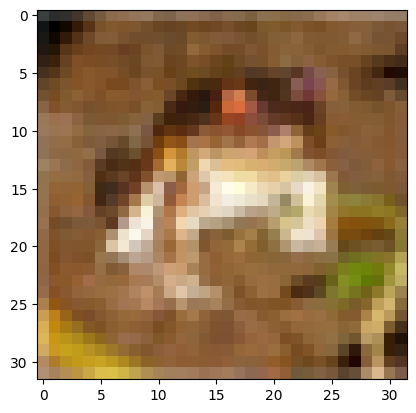

In [4]:
# prompt: train_images 의 첫번째 이미지를 imshow()로 보여줘

import matplotlib.pyplot as plt
plt.imshow(train_images[0])
plt.show()


In [6]:

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [8]:
train_labels 의 첫번째 label 값과 class_names 의 해당 클래스 이름 출력

print(train_labels[0], class_names[train_labels[0][0]])


[6] frog


다운로드한 이미지를 시각화 한다.

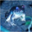

[6]


In [9]:
from google.colab.patches import cv2_imshow
import cv2  # Install opencv-python
cv2_imshow(train_images[0])
cv2.waitKey(2000)
cv2.destroyAllWindows()
print(train_labels[0])

#6번 FROG

## ResNet 모델 가져오기

미리 훈련이 된 신경망인 ResNet을 가져온다.
- trainable=false
- include_top=false  

In [10]:
base_model = ResNet50(include_top=False, pooling = 'avg' , input_shape = (32,32 ,3), weights = 'imagenet')
base_model.trainable = False
print(base_model.summary())

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                      

label 데이터를 수치화 해준다. 라벨바이나리징과 같은 작업이다.

In [11]:
print(train_labels[0])
print(test_labels[0])
input_y = tf.keras.utils.to_categorical(train_labels, 10)
test_y = tf.keras.utils.to_categorical(test_labels, 10)
print(input_y.shape, test_y.shape)
print(input_y[0])
print(test_y[0])

[6]
[3]
(50000, 10) (10000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


#1-2. 분류 모델 구성

전이학습을 위한 모델을 설계한다.    

모델은 기존 ResNet CNN 모델에 CIFAR10분류를 위한 NN레이어를 결합한다.

In [12]:
inputs = Input(shape=(32,32,3))

x = tf.keras.layers.experimental.preprocessing.Resizing(32, 32)(inputs)
x = tf.keras.applications.resnet50.preprocess_input(inputs)

x = base_model(x, training = False)



In [13]:
# Fully Connected에 온전하게 학습을 위해 펼쳐준다
x = Flatten()(x)


In [14]:

# Softmax 함수로 10개 분류하는 분류기
outputs = Dense(10, activation = 'softmax')(x)


In [15]:

# model_res 란 이름의 인풋과 아웃풋이 정해진 모델 생성
model_res = tf.keras.Model(inputs, outputs)
print(model_res.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.__operators__.getitem (  (None, 32, 32, 3)         0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 32, 32, 3)         0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490 

#1-3. 전이학습 모델 구성

pre-trained 모델인 ResNet과 사용자가 정의한 NN을 결합한 전이학습 모델을 구성한다.

In [16]:
model_res.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

#1-4. 전이학습 모델 학습

In [17]:
model_res.fit(train_images, input_y, epochs = 10, validation_data=(test_images, test_y), batch_size= 256)

Epoch 1/10
196/196 [==============================] - 17s 50ms/step - loss: 1.6572 - accuracy: 0.5394 - val_loss: 1.2628 - val_accuracy: 0.6048
Epoch 2/10
196/196 [==============================] - 6s 31ms/step - loss: 1.0953 - accuracy: 0.6435 - val_loss: 1.1414 - val_accuracy: 0.6281
Epoch 3/10
196/196 [==============================] - 6s 31ms/step - loss: 0.9678 - accuracy: 0.6738 - val_loss: 1.0843 - val_accuracy: 0.6441
Epoch 4/10
196/196 [==============================] - 6s 31ms/step - loss: 0.9066 - accuracy: 0.6892 - val_loss: 1.0807 - val_accuracy: 0.6497
Epoch 5/10
196/196 [==============================] - 6s 33ms/step - loss: 0.8677 - accuracy: 0.6998 - val_loss: 1.0757 - val_accuracy: 0.6480
Epoch 6/10
196/196 [==============================] - 6s 32ms/step - loss: 0.8399 - accuracy: 0.7103 - val_loss: 1.0719 - val_accuracy: 0.6530
Epoch 7/10
196/196 [==============================] - 6s 33ms/step - loss: 0.8243 - accuracy: 0.7164 - val_loss: 1.0716 - val_accuracy: 0.650

#테스트하기

In [26]:

# # 이미지 전처리 및 평가
# def preprocess_and_evaluate(images, labels):
#     # 이미지 크기 조정 및 전처리
#     images_resized = tf.image.resize(images, (224, 224))
#     images_preprocessed = preprocess_input(images_resized)

#     # 모델 평가
#     loss, accuracy = model_res.evaluate(images_preprocessed, labels, verbose=0)
#     return loss, accuracy



In [29]:
# 테스트 데이터셋의 일부 이미지로 모델 평가
sample_test_images = test_images[:100]  # 예시로 처음 100개 이미지 사용
sample_test_labels = test_labels[:100]


In [30]:
from tensorflow.keras.utils import to_categorical

# 라벨을 원-핫 인코딩 형식으로 변환
sample_test_labels_one_hot = to_categorical(sample_test_labels, num_classes=10)

# 모델 평가
loss, accuracy = model_res.evaluate(sample_test_images, sample_test_labels_one_hot)

# 평가 결과 출력
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


4/4 [==============================] - 1s 175ms/step - loss: 1.2732 - accuracy: 0.6500
Test Loss: 1.273160457611084, Test Accuracy: 0.6499999761581421


In [31]:
import cv2 as cv
import numpy as np
#from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from google.colab.patches import cv2_imshow


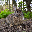

In [63]:
# 이미지를 읽어옵니다.
img1 = cv.imread("rabbit.png")
#img1 = cv.imread("cat.jpg")
#img = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)  # BGR에서 RGB로 색상 체계 변환

# 이미지를 모델이 기대하는 크기로 조정
img_resized = cv2.resize(img1, (32, 32))  # 모델이 기대하는 크기로 이미지 조정

cv2_imshow(img_resized)


In [64]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# 이미지를 모델이 처리할 수 있는 형태로 변환
x = image.img_to_array(img_resized)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)


In [66]:
# 이미지에 대한 예측 수행
predictions = model_res.predict(x)

# 예측 결과 출력
# 예측 결과를 해석하기 위해 decode_predictions를 사용할 수 있습니다 (ResNet50에 적합한 경우)
#print('Predicted:', decode_predictions(predictions, top=3)[0])
# 예측 결과 출력
predicted_class = np.argmax(predictions[0])
print(f'Predicted class: {predicted_class}')

1/1 [==============================] - 0s 22ms/step
Predicted class: 6


In [67]:
# 예측 결과에 대한 클래스 인덱스 찾기
predicted_class_index = np.argmax(predictions[0])

# 인덱스를 클래스 이름으로 매핑 (여기서는 예시로 클래스 이름을 직접 정의함)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
predicted_class_name = class_names[predicted_class_index]

print(f'Predicted class: {predicted_class_name}')


Predicted class: frog
